In [1]:
import re

import numpy as np
import pandas as pd
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Bidirectional
from tensorflow.keras.layers import Embedding, TimeDistributed, Dropout, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_contrib.layers.crf import CRF

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from operator import itemgetter

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zaida\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_excel('dataset\Dataset Text.xlsx')

In [5]:
df.head()

,Kalimat,Label,Text
0,R1,supports,competition can effectively promote the develo...
1,R2,attacks,competition can effectively promote the develo...
2,R3,supports,what we acquired from team work is not only ho...
3,R4,supports,through cooperation children can learn about i...
4,R5,supports,all of these skills help them to get on well w...


In [6]:
df.shape

(1039, 3)

In [7]:
df = df.drop(['Kalimat'],axis=1)

In [8]:
df.head()

,Label,Text
0,supports,competition can effectively promote the develo...
1,attacks,competition can effectively promote the develo...
2,supports,what we acquired from team work is not only ho...
3,supports,through cooperation children can learn about i...
4,supports,all of these skills help them to get on well w...


Text(0.5, 1.0, 'Label Data Distribution')

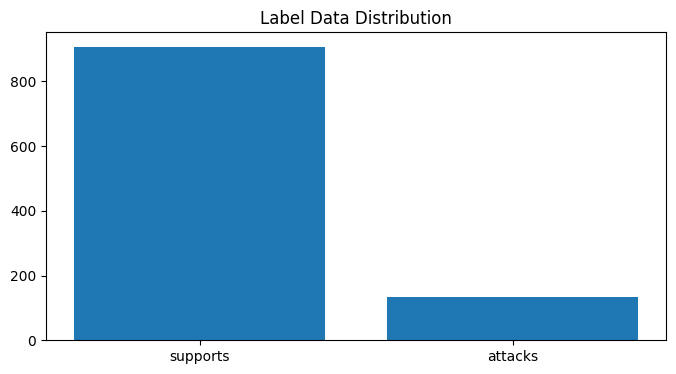

In [9]:
val_count = df.Label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title('Label Data Distribution')

In [10]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# text_cleaning_re = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'

In [11]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    return " ".join(tokens)

In [12]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
tokenizer = Tokenizer()
word_index = tokenizer.word_index

In [15]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 831
Test Data size 208


In [16]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.Text), maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.Text), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (831, 30)
Testing X Shape: (208, 30)


In [17]:
labels = train_data.Label.unique().tolist()

In [18]:
encoder = LabelEncoder()
encoder.fit(train_data.Label.to_list())

y_train = encoder.transform(train_data.Label.to_list())
y_test = encoder.transform(test_data.Label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (831, 1)
y_test shape: (208, 1)


In [19]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [20]:
smote = SMOTE(sampling_strategy='auto',random_state=22)
x_res,y_res = smote.fit_resample(x_train,y_train)

In [21]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [25]:
GLOVE_EMB = 'F:\Zaidan codes\Big Data NLP Project\glove.6B\glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 8
EPOCHS = 10

In [26]:
embeddings_index = {}

f = open(GLOVE_EMB, encoding='utf8')
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [27]:
embedding_matrix = np.zeros((500, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [28]:
embedding_layer = tf.keras.layers.Embedding(500, 300,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [29]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [30]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [31]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on CPU...


In [32]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])


Epoch 1/10
104/104 [==============================] - 10s 38ms/step - loss: 0.6750 - accuracy: 0.8676 - val_loss: 0.6596 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 2/10
104/104 [==============================] - 4s 35ms/step - loss: 0.6407 - accuracy: 0.8773 - val_loss: 0.6296 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 3/10
104/104 [==============================] - 4s 40ms/step - loss: 0.6102 - accuracy: 0.8773 - val_loss: 0.6031 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 4/10
104/104 [==============================] - 6s 54ms/step - loss: 0.5828 - accuracy: 0.8773 - val_loss: 0.5796 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 5/10
104/104 [==============================] - 6s 60ms/step - loss: 0.5581 - accuracy: 0.8773 - val_loss: 0.5585 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 6/10
104/104 [==============================] - 5s 44ms/step - loss: 0.5362 - accuracy: 0.8773 - val_loss: 0.5401 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 7/10
104/104 [==============================] - 6s 62ms/s

In [33]:
print('Loss and Accuracy Score :', model.evaluate(x_test, y_test))

7/7 [==============================] - 1s 10ms/step - loss: 0.4855 - accuracy: 0.8510
Loss and Accuracy Score : [0.4855439066886902, 0.8509615659713745]


In [34]:
y_pred = model.predict(x_test, batch_size=BATCH_SIZE)
print(classification_report(y_test, y_pred.round()))

26/26 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.85      1.00      0.92       177

    accuracy                           0.85       208
   macro avg       0.43      0.50      0.46       208
weighted avg       0.72      0.85      0.78       208



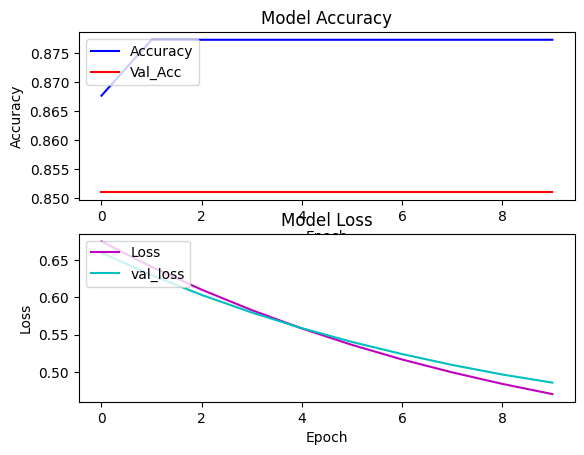

In [46]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('Model Accuracy')
at.set_ylabel('Accuracy')
at.set_xlabel('Epoch')
at.legend(['Accuracy', 'Val_Acc'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('Model Loss')
al.set_ylabel('Loss')
al.set_xlabel('Epoch')
al.legend(['Loss', 'val_loss'], loc = 'upper left')